In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17093720489183991733,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1980112158150973784
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15695549568
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15189336133101165696
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 276347429385545533
 physical_device_desc: "device: XLA_GPU device"]

In [3]:
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
# from sklearn.metrics import log_loss
import sys
# import time
import math
import os
import pandas as pd
# from keras.callbacks import EarlyStopping
import numpy as np
# from glob import glob
# import cv2
# import skimage
# from skimage.transform import resize
from keras.utils.np_utils import to_categorical
# import keras
# from keras import layers
# from keras import models
# from keras import optimizers
# from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input,concatenate
# from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
# from keras.applications.vgg19 import VGG19
from keras.regularizers import l2, l1

import matplotlib.pyplot as plt
# from keras.layers import Input, concatenate
# from keras import optimizers, metrics, models
# from keras.layers import Input, Flatten, Dense

%matplotlib inline

In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.4.3
tensorflow Version 2.3.0


In [5]:
batch_size = 32
img_height, img_width = 800, 600
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
print(os.listdir("../input/keras-pretrained-models/"))

['vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'Kuszma.JPG', 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5', 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5', 'imagenet_class_index.json', 'xception_weights_tf_dim_ordering_tf_kernels.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5', 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5']


In [7]:
# print(os.listdir("../input/full-keras-pretrained-no-top"))

In [8]:
train_dir = '../input/data-pig/train/'
test_dir = '../input/data-pig/test/'

In [9]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 7556 images belonging to 4 classes.
Found 2517 images belonging to 4 classes.
Found 1776 images belonging to 4 classes.


In [10]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 7556
nb_validation_samples: 2517
nb_test_samples: 1776

predict_size_train: 237
predict_size_validation: 79
predict_size_test: 56

 num_classes: 4


In [11]:
vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"
xception_weights ="../input/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [12]:
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
from keras.applications import DenseNet121
from keras.applications import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import NASNetLarge, NASNetMobile
from keras.applications import MobileNet

input_tensor = Input(shape = input_shape)  

base_model1=DenseNet201(weights=denseNet201_weights, include_top=False, pooling = "avg")

bottleneck_final_model = base_model1

In [13]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [14]:
os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/" 
model_name = "DenseNet201_descriptors"

In [15]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [16]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [17]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [18]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [19]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [20]:
model = Sequential()
model.add(Dense(512, activation="selu", kernel_regularizer=l2(1e-06), bias_regularizer=l2(1e-05), activity_regularizer=l1(0.0001)))

model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

adam_opt=Adam(lr = 1e-06, beta_1=0.7, beta_2=0.5)
model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

Epoch 1/1000
237/237 - 1s - loss: 1.5206 - accuracy: 0.3289 - val_loss: 1.3288 - val_accuracy: 0.3770
Epoch 2/1000
237/237 - 1s - loss: 1.4495 - accuracy: 0.3413 - val_loss: 1.2938 - val_accuracy: 0.3774
Epoch 3/1000
237/237 - 1s - loss: 1.4060 - accuracy: 0.3646 - val_loss: 1.2592 - val_accuracy: 0.3842
Epoch 4/1000
237/237 - 1s - loss: 1.3544 - accuracy: 0.3933 - val_loss: 1.2270 - val_accuracy: 0.3909
Epoch 5/1000
237/237 - 1s - loss: 1.3057 - accuracy: 0.4099 - val_loss: 1.1951 - val_accuracy: 0.4068
Epoch 6/1000
237/237 - 1s - loss: 1.2469 - accuracy: 0.4517 - val_loss: 1.1631 - val_accuracy: 0.4930
Epoch 7/1000
237/237 - 1s - loss: 1.2145 - accuracy: 0.4663 - val_loss: 1.1310 - val_accuracy: 0.5411
Epoch 8/1000
237/237 - 1s - loss: 1.1593 - accuracy: 0.5079 - val_loss: 1.1009 - val_accuracy: 0.6456
Epoch 9/1000
237/237 - 1s - loss: 1.1258 - accuracy: 0.5273 - val_loss: 1.0713 - val_accuracy: 0.7124
Epoch 10/1000
237/237 - 1s - loss: 1.0776 - accuracy: 0.5487 - val_loss: 1.0422 - 

Epoch 81/1000
237/237 - 1s - loss: 0.0651 - accuracy: 0.9981 - val_loss: 0.1288 - val_accuracy: 0.9956
Epoch 82/1000
237/237 - 1s - loss: 0.0633 - accuracy: 0.9984 - val_loss: 0.1237 - val_accuracy: 0.9960
Epoch 83/1000
237/237 - 1s - loss: 0.0615 - accuracy: 0.9987 - val_loss: 0.1217 - val_accuracy: 0.9960
Epoch 84/1000
237/237 - 1s - loss: 0.0598 - accuracy: 0.9985 - val_loss: 0.1189 - val_accuracy: 0.9956
Epoch 85/1000
237/237 - 1s - loss: 0.0588 - accuracy: 0.9980 - val_loss: 0.1164 - val_accuracy: 0.9956
Epoch 86/1000
237/237 - 1s - loss: 0.0579 - accuracy: 0.9980 - val_loss: 0.1140 - val_accuracy: 0.9960
Epoch 87/1000
237/237 - 1s - loss: 0.0547 - accuracy: 0.9988 - val_loss: 0.1115 - val_accuracy: 0.9960
Epoch 88/1000
237/237 - 1s - loss: 0.0539 - accuracy: 0.9984 - val_loss: 0.1098 - val_accuracy: 0.9956
Epoch 89/1000
237/237 - 1s - loss: 0.0531 - accuracy: 0.9983 - val_loss: 0.1074 - val_accuracy: 0.9960
Epoch 90/1000
237/237 - 1s - loss: 0.0506 - accuracy: 0.9992 - val_loss: 

Epoch 160/1000
237/237 - 1s - loss: 0.0181 - accuracy: 0.9995 - val_loss: 0.0404 - val_accuracy: 0.9960
Epoch 161/1000
237/237 - 1s - loss: 0.0178 - accuracy: 0.9995 - val_loss: 0.0404 - val_accuracy: 0.9956
Epoch 162/1000
237/237 - 1s - loss: 0.0177 - accuracy: 0.9993 - val_loss: 0.0406 - val_accuracy: 0.9956
Epoch 163/1000
237/237 - 1s - loss: 0.0177 - accuracy: 0.9993 - val_loss: 0.0402 - val_accuracy: 0.9956
Epoch 164/1000
237/237 - 1s - loss: 0.0175 - accuracy: 0.9995 - val_loss: 0.0397 - val_accuracy: 0.9956
Epoch 165/1000
237/237 - 1s - loss: 0.0172 - accuracy: 0.9995 - val_loss: 0.0389 - val_accuracy: 0.9960
Epoch 166/1000
237/237 - 1s - loss: 0.0175 - accuracy: 0.9992 - val_loss: 0.0393 - val_accuracy: 0.9956
Epoch 167/1000
237/237 - 1s - loss: 0.0167 - accuracy: 0.9995 - val_loss: 0.0387 - val_accuracy: 0.9956
Epoch 168/1000
237/237 - 1s - loss: 0.0168 - accuracy: 0.9993 - val_loss: 0.0384 - val_accuracy: 0.9960
Epoch 169/1000
237/237 - 1s - loss: 0.0166 - accuracy: 0.9995 - 

Epoch 239/1000
237/237 - 1s - loss: 0.0126 - accuracy: 0.9995 - val_loss: 0.0288 - val_accuracy: 0.9964
Epoch 240/1000
237/237 - 1s - loss: 0.0123 - accuracy: 0.9996 - val_loss: 0.0282 - val_accuracy: 0.9964
Epoch 241/1000
237/237 - 1s - loss: 0.0123 - accuracy: 0.9996 - val_loss: 0.0283 - val_accuracy: 0.9964
Epoch 242/1000
237/237 - 1s - loss: 0.0119 - accuracy: 0.9996 - val_loss: 0.0276 - val_accuracy: 0.9964
Epoch 243/1000
237/237 - 1s - loss: 0.0121 - accuracy: 0.9995 - val_loss: 0.0280 - val_accuracy: 0.9964
Epoch 244/1000
237/237 - 1s - loss: 0.0121 - accuracy: 0.9996 - val_loss: 0.0276 - val_accuracy: 0.9964
Epoch 245/1000
237/237 - 1s - loss: 0.0120 - accuracy: 0.9995 - val_loss: 0.0279 - val_accuracy: 0.9964
Epoch 246/1000
237/237 - 1s - loss: 0.0121 - accuracy: 0.9995 - val_loss: 0.0276 - val_accuracy: 0.9964
Epoch 247/1000
237/237 - 1s - loss: 0.0120 - accuracy: 0.9995 - val_loss: 0.0271 - val_accuracy: 0.9964
Epoch 248/1000
237/237 - 1s - loss: 0.0121 - accuracy: 0.9995 - 

Epoch 318/1000
237/237 - 1s - loss: 0.0103 - accuracy: 0.9996 - val_loss: 0.0243 - val_accuracy: 0.9960
Epoch 319/1000
237/237 - 1s - loss: 0.0103 - accuracy: 0.9996 - val_loss: 0.0244 - val_accuracy: 0.9960
Epoch 320/1000
237/237 - 1s - loss: 0.0101 - accuracy: 0.9996 - val_loss: 0.0239 - val_accuracy: 0.9960
Epoch 321/1000
237/237 - 1s - loss: 0.0102 - accuracy: 0.9996 - val_loss: 0.0240 - val_accuracy: 0.9960
Epoch 322/1000
237/237 - 1s - loss: 0.0101 - accuracy: 0.9995 - val_loss: 0.0236 - val_accuracy: 0.9960
Epoch 323/1000
237/237 - 1s - loss: 0.0100 - accuracy: 0.9996 - val_loss: 0.0232 - val_accuracy: 0.9960
Epoch 324/1000
237/237 - 1s - loss: 0.0102 - accuracy: 0.9996 - val_loss: 0.0236 - val_accuracy: 0.9960
Epoch 325/1000
237/237 - 1s - loss: 0.0101 - accuracy: 0.9996 - val_loss: 0.0239 - val_accuracy: 0.9960
Epoch 326/1000
237/237 - 1s - loss: 0.0100 - accuracy: 0.9996 - val_loss: 0.0238 - val_accuracy: 0.9960
Epoch 327/1000
237/237 - 1s - loss: 0.0101 - accuracy: 0.9995 - 

Epoch 397/1000
237/237 - 1s - loss: 0.0090 - accuracy: 0.9997 - val_loss: 0.0214 - val_accuracy: 0.9968
Epoch 398/1000
237/237 - 1s - loss: 0.0089 - accuracy: 0.9996 - val_loss: 0.0216 - val_accuracy: 0.9964
Epoch 399/1000
237/237 - 1s - loss: 0.0089 - accuracy: 0.9997 - val_loss: 0.0210 - val_accuracy: 0.9968
Epoch 400/1000
237/237 - 1s - loss: 0.0091 - accuracy: 0.9997 - val_loss: 0.0210 - val_accuracy: 0.9968
Epoch 401/1000
237/237 - 1s - loss: 0.0089 - accuracy: 0.9996 - val_loss: 0.0216 - val_accuracy: 0.9964
Epoch 402/1000
237/237 - 1s - loss: 0.0088 - accuracy: 0.9996 - val_loss: 0.0220 - val_accuracy: 0.9964
Epoch 403/1000
237/237 - 1s - loss: 0.0088 - accuracy: 0.9997 - val_loss: 0.0209 - val_accuracy: 0.9968
Epoch 404/1000
237/237 - 1s - loss: 0.0089 - accuracy: 0.9996 - val_loss: 0.0209 - val_accuracy: 0.9968
Epoch 405/1000
237/237 - 1s - loss: 0.0088 - accuracy: 0.9997 - val_loss: 0.0209 - val_accuracy: 0.9968
Epoch 406/1000
237/237 - 1s - loss: 0.0088 - accuracy: 0.9997 - 

Epoch 476/1000
237/237 - 1s - loss: 0.0081 - accuracy: 0.9997 - val_loss: 0.0199 - val_accuracy: 0.9972
Epoch 477/1000
237/237 - 1s - loss: 0.0081 - accuracy: 0.9997 - val_loss: 0.0197 - val_accuracy: 0.9972
Epoch 478/1000
237/237 - 1s - loss: 0.0080 - accuracy: 0.9997 - val_loss: 0.0199 - val_accuracy: 0.9972
Epoch 479/1000
237/237 - 1s - loss: 0.0081 - accuracy: 0.9996 - val_loss: 0.0195 - val_accuracy: 0.9968
Epoch 480/1000
237/237 - 1s - loss: 0.0081 - accuracy: 0.9997 - val_loss: 0.0195 - val_accuracy: 0.9968
Epoch 481/1000
237/237 - 1s - loss: 0.0081 - accuracy: 0.9997 - val_loss: 0.0194 - val_accuracy: 0.9972
Epoch 482/1000
237/237 - 1s - loss: 0.0081 - accuracy: 0.9997 - val_loss: 0.0194 - val_accuracy: 0.9972
Epoch 483/1000
237/237 - 1s - loss: 0.0081 - accuracy: 0.9997 - val_loss: 0.0197 - val_accuracy: 0.9972
Epoch 484/1000
237/237 - 1s - loss: 0.0079 - accuracy: 0.9997 - val_loss: 0.0192 - val_accuracy: 0.9968
Epoch 485/1000
237/237 - 1s - loss: 0.0081 - accuracy: 0.9997 - 

Epoch 555/1000
237/237 - 1s - loss: 0.0076 - accuracy: 0.9997 - val_loss: 0.0187 - val_accuracy: 0.9972
Epoch 556/1000
237/237 - 1s - loss: 0.0075 - accuracy: 0.9997 - val_loss: 0.0185 - val_accuracy: 0.9972
Epoch 557/1000
237/237 - 1s - loss: 0.0075 - accuracy: 0.9996 - val_loss: 0.0183 - val_accuracy: 0.9972
Epoch 558/1000
237/237 - 1s - loss: 0.0075 - accuracy: 0.9996 - val_loss: 0.0187 - val_accuracy: 0.9972
Epoch 559/1000
237/237 - 1s - loss: 0.0075 - accuracy: 0.9996 - val_loss: 0.0182 - val_accuracy: 0.9972
Epoch 560/1000
237/237 - 1s - loss: 0.0073 - accuracy: 0.9997 - val_loss: 0.0183 - val_accuracy: 0.9972
Epoch 561/1000
237/237 - 1s - loss: 0.0074 - accuracy: 0.9997 - val_loss: 0.0183 - val_accuracy: 0.9972
Epoch 562/1000
237/237 - 1s - loss: 0.0074 - accuracy: 0.9997 - val_loss: 0.0183 - val_accuracy: 0.9972
Epoch 563/1000
237/237 - 1s - loss: 0.0076 - accuracy: 0.9997 - val_loss: 0.0182 - val_accuracy: 0.9972
Epoch 564/1000
237/237 - 1s - loss: 0.0074 - accuracy: 0.9997 - 

Epoch 634/1000
237/237 - 1s - loss: 0.0070 - accuracy: 0.9997 - val_loss: 0.0177 - val_accuracy: 0.9972
Epoch 635/1000
237/237 - 1s - loss: 0.0069 - accuracy: 0.9997 - val_loss: 0.0176 - val_accuracy: 0.9972
Epoch 636/1000
237/237 - 1s - loss: 0.0069 - accuracy: 0.9997 - val_loss: 0.0180 - val_accuracy: 0.9976
Epoch 637/1000
237/237 - 1s - loss: 0.0069 - accuracy: 0.9997 - val_loss: 0.0177 - val_accuracy: 0.9972
Epoch 638/1000
237/237 - 1s - loss: 0.0069 - accuracy: 0.9997 - val_loss: 0.0177 - val_accuracy: 0.9972
Epoch 639/1000
237/237 - 1s - loss: 0.0068 - accuracy: 0.9997 - val_loss: 0.0177 - val_accuracy: 0.9972
Epoch 640/1000
237/237 - 1s - loss: 0.0071 - accuracy: 0.9997 - val_loss: 0.0177 - val_accuracy: 0.9972
Epoch 641/1000
237/237 - 1s - loss: 0.0068 - accuracy: 0.9997 - val_loss: 0.0174 - val_accuracy: 0.9972
Epoch 642/1000
237/237 - 1s - loss: 0.0068 - accuracy: 0.9997 - val_loss: 0.0177 - val_accuracy: 0.9972
Epoch 643/1000
237/237 - 1s - loss: 0.0070 - accuracy: 0.9997 - 

Epoch 713/1000
237/237 - 1s - loss: 0.0064 - accuracy: 0.9997 - val_loss: 0.0175 - val_accuracy: 0.9976
Epoch 714/1000
237/237 - 1s - loss: 0.0065 - accuracy: 0.9996 - val_loss: 0.0173 - val_accuracy: 0.9976
Epoch 715/1000
237/237 - 1s - loss: 0.0065 - accuracy: 0.9997 - val_loss: 0.0171 - val_accuracy: 0.9972
Epoch 716/1000
237/237 - 1s - loss: 0.0064 - accuracy: 0.9997 - val_loss: 0.0171 - val_accuracy: 0.9976
Epoch 717/1000
237/237 - 1s - loss: 0.0067 - accuracy: 0.9996 - val_loss: 0.0168 - val_accuracy: 0.9972
Epoch 718/1000
237/237 - 1s - loss: 0.0063 - accuracy: 0.9997 - val_loss: 0.0171 - val_accuracy: 0.9976
Epoch 719/1000
237/237 - 1s - loss: 0.0065 - accuracy: 0.9997 - val_loss: 0.0171 - val_accuracy: 0.9976
Epoch 720/1000
237/237 - 1s - loss: 0.0064 - accuracy: 0.9999 - val_loss: 0.0171 - val_accuracy: 0.9976
Epoch 721/1000
237/237 - 1s - loss: 0.0064 - accuracy: 0.9997 - val_loss: 0.0170 - val_accuracy: 0.9976
Epoch 722/1000
237/237 - 1s - loss: 0.0065 - accuracy: 0.9996 - 

Epoch 792/1000
237/237 - 1s - loss: 0.0062 - accuracy: 0.9997 - val_loss: 0.0164 - val_accuracy: 0.9976
Epoch 793/1000
237/237 - 1s - loss: 0.0058 - accuracy: 0.9999 - val_loss: 0.0164 - val_accuracy: 0.9976
Epoch 794/1000
237/237 - 1s - loss: 0.0060 - accuracy: 0.9997 - val_loss: 0.0163 - val_accuracy: 0.9976
Epoch 795/1000
237/237 - 1s - loss: 0.0060 - accuracy: 0.9997 - val_loss: 0.0167 - val_accuracy: 0.9976
Epoch 796/1000
237/237 - 1s - loss: 0.0063 - accuracy: 0.9996 - val_loss: 0.0166 - val_accuracy: 0.9976
Epoch 797/1000
237/237 - 1s - loss: 0.0061 - accuracy: 0.9997 - val_loss: 0.0167 - val_accuracy: 0.9976
Epoch 798/1000
237/237 - 1s - loss: 0.0060 - accuracy: 0.9997 - val_loss: 0.0163 - val_accuracy: 0.9976
Epoch 799/1000
237/237 - 1s - loss: 0.0058 - accuracy: 0.9999 - val_loss: 0.0166 - val_accuracy: 0.9976
Epoch 800/1000
237/237 - 1s - loss: 0.0060 - accuracy: 0.9997 - val_loss: 0.0166 - val_accuracy: 0.9976
Epoch 801/1000
237/237 - 1s - loss: 0.0061 - accuracy: 0.9997 - 

Epoch 871/1000
237/237 - 1s - loss: 0.0057 - accuracy: 0.9999 - val_loss: 0.0161 - val_accuracy: 0.9976
Epoch 872/1000
237/237 - 1s - loss: 0.0058 - accuracy: 0.9999 - val_loss: 0.0160 - val_accuracy: 0.9976
Epoch 873/1000
237/237 - 1s - loss: 0.0057 - accuracy: 0.9999 - val_loss: 0.0158 - val_accuracy: 0.9976
Epoch 874/1000
237/237 - 1s - loss: 0.0058 - accuracy: 0.9997 - val_loss: 0.0159 - val_accuracy: 0.9976
Epoch 875/1000
237/237 - 1s - loss: 0.0056 - accuracy: 0.9999 - val_loss: 0.0156 - val_accuracy: 0.9976
Epoch 876/1000
237/237 - 1s - loss: 0.0056 - accuracy: 0.9999 - val_loss: 0.0160 - val_accuracy: 0.9976
Epoch 877/1000
237/237 - 1s - loss: 0.0058 - accuracy: 0.9999 - val_loss: 0.0164 - val_accuracy: 0.9976
Epoch 878/1000
237/237 - 1s - loss: 0.0058 - accuracy: 0.9999 - val_loss: 0.0160 - val_accuracy: 0.9976
Epoch 879/1000
237/237 - 1s - loss: 0.0057 - accuracy: 0.9997 - val_loss: 0.0162 - val_accuracy: 0.9976
Epoch 880/1000
237/237 - 1s - loss: 0.0058 - accuracy: 0.9997 - 

Epoch 950/1000
237/237 - 1s - loss: 0.0056 - accuracy: 0.9997 - val_loss: 0.0156 - val_accuracy: 0.9976
Epoch 951/1000
237/237 - 1s - loss: 0.0054 - accuracy: 0.9997 - val_loss: 0.0155 - val_accuracy: 0.9976
Epoch 952/1000
237/237 - 1s - loss: 0.0055 - accuracy: 0.9999 - val_loss: 0.0155 - val_accuracy: 0.9976
Epoch 953/1000
237/237 - 1s - loss: 0.0056 - accuracy: 0.9997 - val_loss: 0.0158 - val_accuracy: 0.9976
Epoch 954/1000
237/237 - 1s - loss: 0.0054 - accuracy: 0.9999 - val_loss: 0.0153 - val_accuracy: 0.9976
Epoch 955/1000
237/237 - 1s - loss: 0.0054 - accuracy: 0.9997 - val_loss: 0.0156 - val_accuracy: 0.9976
Epoch 956/1000
237/237 - 1s - loss: 0.0055 - accuracy: 0.9997 - val_loss: 0.0156 - val_accuracy: 0.9976
Epoch 957/1000
237/237 - 1s - loss: 0.0054 - accuracy: 0.9999 - val_loss: 0.0159 - val_accuracy: 0.9976
Epoch 958/1000
237/237 - 1s - loss: 0.0055 - accuracy: 0.9999 - val_loss: 0.0156 - val_accuracy: 0.9976
Epoch 959/1000
237/237 - 1s - loss: 0.0054 - accuracy: 0.9997 - 

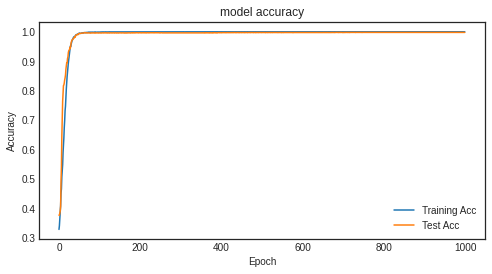

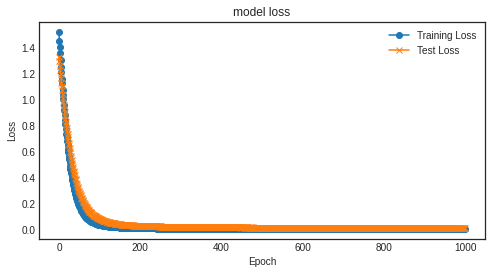

<Figure size 432x288 with 0 Axes>

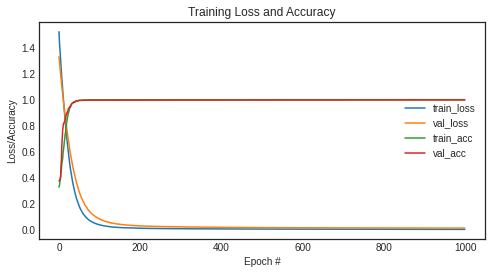

In [21]:
import seaborn
plt.style.use('seaborn-white')
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='lower right')
plt.show()

# summarize history for loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'x-')
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper right')

plt.show()

plt.figure()
plt.figure(figsize=(8,4))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")

In [22]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

79/79 [==============================] - 0s 2ms/step - loss: 0.0153 - accuracy: 0.9976
Validation Accuracy: 99.7616%
Validation Loss: 0.015269399620592594


In [23]:
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score

preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9977477477477478


Confusion Matrix
[[354   0   0   0]
 [  0 410   0   2]
 [  1   1 653   0]
 [  0   0   0 355]]


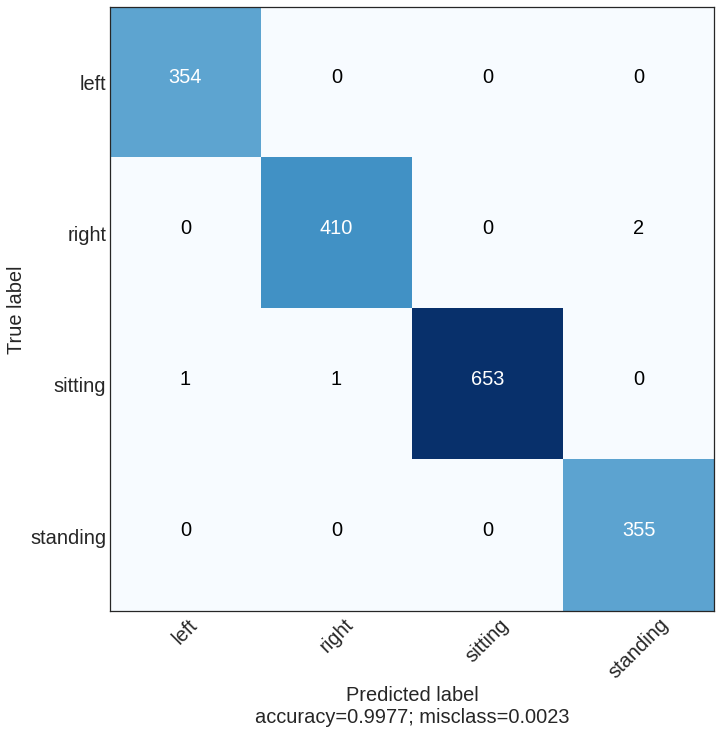

In [24]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[354   0   0   0]
 [  0 410   0   2]
 [  1   1 653   0]
 [  0   0   0 355]]
              precision    recall  f1-score   support

        left       1.00      1.00      1.00       354
       right       1.00      1.00      1.00       412
     sitting       1.00      1.00      1.00       655
    standing       0.99      1.00      1.00       355

    accuracy                           1.00      1776
   macro avg       1.00      1.00      1.00      1776
weighted avg       1.00      1.00      1.00      1776



In [26]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  100.0
Specificity :  100.0


In [27]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

56/56 [==============================] - 0s 1ms/step
Precision =  0.9977542726875995
Recall =  0.9977477477477478
f1_score =  0.9977478392765492


In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9985780838770497


In [29]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

56/56 [==============================] - 0s 1ms/step


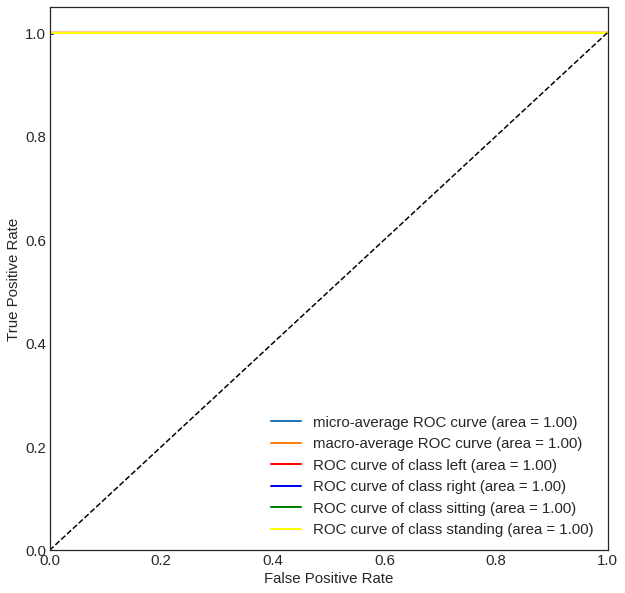

In [30]:
from sklearn.preprocessing import label_binarize

lw = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1, 2, 3])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

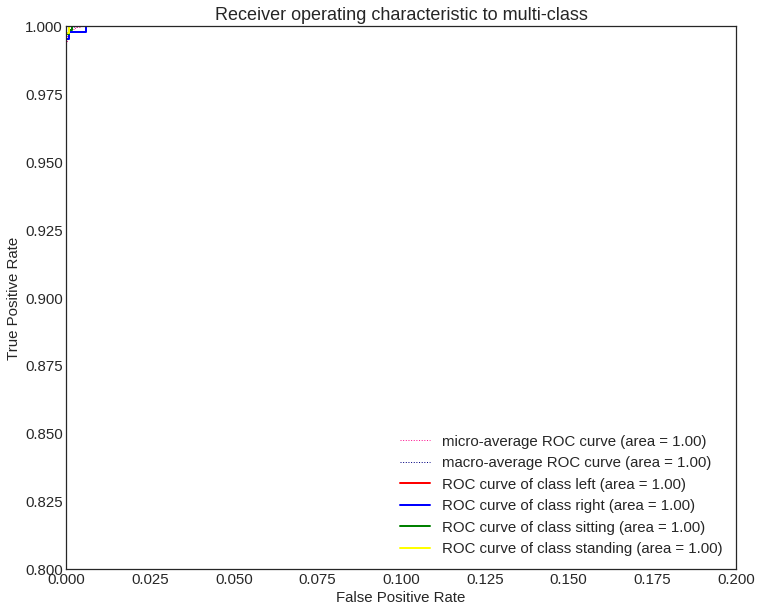

In [31]:
# Zoom in view of the upper left corner.
plt.figure(figsize=(12,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)


plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=1)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=1)

colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")

plt.show()

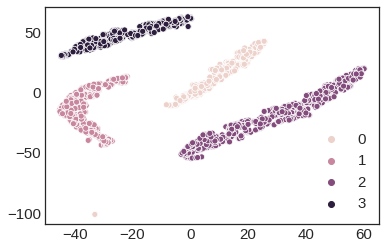

In [32]:
from sklearn.manifold.t_sne import TSNE

model_predictions = np.vstack(preds)
classes = np.hstack(y_pred)

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(model_predictions)

seaborn.scatterplot(tsne_data[:,0], tsne_data[:,1], hue=classes)

In [33]:
output_filename = "Pig_DenseNet201"
dir_name = "/kaggle/working"

import shutil
shutil.make_archive(output_filename, "zip", dir_name)

'/kaggle/working/Pig_DenseNet201.zip'

In [ ]:
print("Done!!!")